# 34-35 并发安全字典sync.Map


到目前为止我们基本学习了go语言自带的同步工具。本节我们会学习一个关于并发安全的高级数据结构`sync.Map`。众所周知，Go语言自带的字典类型，map并不是并发安全的。

# 前导知识：并发安全字典诞生史

换句话说，在同一时间段内，让不同goroutine中的代码，对同一个字典进行读写操作是不安全的。字典值本身可能会因这些操作而产生混乱，相关的程序也可能会因此发生不可预知的问题。

在`sync.Map`出现之前，我们如果要实现并发安全的字典，就只能自行构建。不过，这其实也不是什么麻烦事，使用 `sync.Mutex`或`sync.RWMutex`，再加上原生的`map`就可以轻松地做到。

GitHub网站上已经有很多库提供了类似的数据结构。我在《Go并发编程实战》的第2版中也提供了一个比较完整的并发安全字典的实现。它的性能比同类的数据结构还要好一些，因为它在很大程度上有效地避免了对锁的依赖。

尽管已经有了不少的参考实现，Go语言爱好者们还是希望Go语言官方能够发布一个标准的并发安全字典。

经过大家多年的建议和吐槽，Go语言官方终于在2017年发布的Go 1.9中，正式加入了并发安全的字典类型`sync.Map`。

这个字典类型提供了一些常用的键值存取操作方法，并保证了这些操作的并发安全。同时，它的存、取、删等操作都可以基本保证在常数时间内执行完毕。换句话说，它们的算法复杂度与`map`类型一样都是O(1)的。

在有些时候，与单纯使用原生`map`和互斥锁的方案相比，使用`sync.Map`可以显著地减少锁的争用。`sync.Map`本身虽然也用到了锁，但是，它其实在尽可能地避免使用锁。

我们都知道，**使用锁就意味着要把一些并发的操作强制串行化。这往往会降低程序的性能**，尤其是在计算机拥有多个CPU核心的情况下。

因此，我们常说，能用原子操作就不要用锁，不过这很有局限性，毕竟原子只能对一些基本的数据类型提供支持。

无论在何种场景下使用`sync.Map`，我们都需要注意，与原生`map`明显不同，它只是Go语言标准库中的一员，而不是语言层面的东西。也正因为这一点，`Go`语言的编译器并不会对它的键和值，进行特殊的类型检查。

如果你看过`sync.Map`的文档或者实际使用过它，那么就一定会知道，它所有的方法涉及的键和值的类型都是`interface{}`，也就是空接口，这意味着可以包罗万象。所以，我们**必须在程序中自行保证它的键类型和值类型的正确性**。

好了，现在第一个问题来了。**今天的问题是：并发安全字典对键的类型有要求吗**？

这道题的典型回答是：有要求。键的实际类型不能是**函数类型、字典类型和切片类型**。

解析一下这个问题。 我们都知道，Go语言的原生字典的键类型不能是函数类型、字典类型和切片类型。

由于并发安全字典内部使用的存储介质正是原生字典，又因为它使用的<u>原生字典键类型</u>也是可以包罗万象的interface{}；所以，我们绝对不能带着任何实际类型为函数类型、字典类型或切片类型的键值去操作并发安全字典。

<u>由于这些键值的实际类型只有在程序运行期间才能够确定，所以Go语言编译器是无法在编译期对它们进行检查的，不正确的键值实际类型肯定会引发panic</u>。

因此，我们在这里首先要做的一件事就是：一定不要违反上述规则。我们应该在每次操作并发安全字典的时候，都去显式地检查键值的实际类型。无论是存、取还是删，都应该如此。

当然，更好的做法是，把针对同一个并发安全字典的这几种操作都集中起来，然后**统一地编写检查代码**。除此之外，把并发安全字典封装在一个结构体类型中，往往是一个很好的选择。

总之，我们必须保证键的类型是可比较的（或者说可判等的）。如果你实在拿不准，那么可以先通过调用**reflect.TypeOf**函数得到一个键值对应的反射类型值（即：**reflect.Type**类型的值），然后再调用这个值的Comparable方法，得到确切的判断结果。

## 知识扩展
**问题一：怎样保证并发安全字典中的键和值的类型正确性？** 方案一：
简单地说，可以使用类型断言表达式或者反射操作来保证它们的类型正确性。

为了进一步明确并发安全字典中键值的实际类型，这里大致有两种方案可选。

**第一种方案是，让并发安全字典只能存储某个特定类型的键**。

比如，指定这里的键只能是int类型的，或者只能是字符串，又或是某类结构体。一旦完全确定了键的类型，你就可以在进行存、取、删操作的时候，使用类型断言表达式去对键的类型做检查了。

一般情况下，这种检查并不繁琐。而且，你要是把并发安全字典封装在一个结构体类型里面，那就更加方便了。你这时完全可以让Go语言编译器帮助你做类型检查。请看下面的代码：

In [ ]:
type IntStrMap struct {
 m sync.Map
}

func (iMap *IntStrMap) Delete(key int) {
 iMap.m.Delete(key)
}

func (iMap *IntStrMap) Load(key int) (value string, ok bool) {
 v, ok := iMap.m.Load(key)
 if v != nil {
  value = v.(string)
 }
 return
}

func (iMap *IntStrMap) LoadOrStore(key int, value string) (actual string, loaded bool) {
 a, loaded := iMap.m.LoadOrStore(key, value)
 actual = a.(string)
 return
}

func (iMap *IntStrMap) Range(f func(key int, value string) bool) {// 
    // Range方法接受一个函数f作为参数。该函数f的参数类型是int和string，返回值类型是bool。
 f1 := func(key, value interface{}) bool {
  return f(key.(int), value.(string))
 }
 iMap.m.Range(f1)
}

func (iMap *IntStrMap) Store(key int, value string) {
 iMap.m.Store(key, value)
}

如上所示，我编写了一个名为`IntStrMap`的结构体类型，它代表了键类型为`int`、值类型为`string`的并发安全字典。在这个结构体类型中，只有一个`sync.Map`类型的字段`m`。并且，这个类型拥有的所有方法，都与`sync.Map`类型的方法非常类似。

两者对应的方法名称完全一致，方法签名也非常相似，只不过，与键和值相关的那些参数和结果的类型不同而已。在`IntStrMap`类型的方法签名中，明确了键的类型为`int`，且值的类型为`string`。

显然，这些方法在接受键和值的时候，就不用再做类型检查了。另外，这些方法在从`m`中取出键和值的时候，完全不用担心它们的类型会不正确，因为它的正确性在当初存入的时候，就已经由Go语言编译器保证了。

稍微总结一下。第一种方案适用于**我们可以完全确定键和值的具体类型的情况**。在这种情况下，我们可以利用Go语言编译器去做类型检查，并用类型断言表达式作为辅助，就像`IntStrMap`那样。

## 总结
我们今天讨论的是`sync.Map`类型，它是一种并发安全的字典。它提供了一些常用的键、值存取操作方法，并保证了这些操作的并发安全。同时，它还保证了存、取、删等操作的常数级执行时间。

与原生的字典相同，并发安全字典对键的类型也是有要求的。它们同样不能是函数类型、字典类型和切片类型。

另外，由于并发安全字典提供的方法涉及的键和值的类型都是`interface{}`，所以我们在调用这些方法的时候，往往还需要对键和值的实际类型进行检查。

这里大致有两个方案。我们今天主要提到了第一种方案，这是在编码时就完全确定键和值的类型，然后利用Go语言的编译器帮我们做检查。

在下一次的文章中，我们会提到另外一种方案，并对比这两种方案的优劣。除此之外，我会继续探讨并发安全字典的相关问题。

# 35 并发安全字典sync.Map(下)

上面主要介绍的是第一种方案，在编码的时候就完全确定键和值的类型，然后让编译器来帮我们进行类型检查。方便且有效但是字典类型缺少了灵活性。

## 知识扩展
**问题1：怎样保证并发安全字典中的键和值的类型正确性？-方案二**

那么，如果我们既想保持`sync.Map`类型原有的灵活性，又想约束键和值的类型，那么应该怎样做呢？这就涉及了第二个方案。

**在第二种方案中，我们封装的结构体类型的所有方法，都可以与`sync.Map`类型的方法完全一致（包括方法名称和方法签名）。**

不过，在这些方法中，我们就需要添加一些做**类型检查**的代码了。另外，这样并发安全字典的键类型和值类型，必须在初始化的时候就完全确定。并且，这种情况下，我们必须先要保证键的类型是可比较的。

所以在设计这样的结构体类型的时候，只包含`sync.Map`类型的字段就不够了。

比如：


In [ ]:
type ConcurrentMap struct {
 m         sync.Map
 keyType   reflect.Type
 valueType reflect.Type
}

这里`ConcurrentMap`类型代表的是：可自定义键类型和值类型的并发安全字典。这个类型同样有一个`sync.Map`类型的字段m，代表着其内部使用的并发安全字典。

另外，它的字段`keyType`和`valueType`，分别用于**保存键类型和值类型**。这两个字段的类型都是`reflect.Type`，我们可称之为**反射类型**。

这个类型可以代表Go语言的任何数据类型。并且，这个类型的值也非常容易获得：通过调用`reflect.TypeOf`函数并把某个样本值传入即可。

调用表达式`reflect.TypeOf(int(123))`的结果值，就代表了`int`类型的反射类型值。

我们现在来看一看`ConcurrentMap`类型方法应该怎么写。

先说`Load`方法，这个方法接受一个`interface{}`类型的参数`key`，参数`key`代表了某个键的值。

因此，当我们根据`ConcurrentMap`在`m`字段的值中查找键值对的时候，就必须保证`ConcurrentMap`的类型是正确的。由于反射类型值之间可以直接使用操作符==或!=进行判等，所以这里的类型检查代码非常简单。

In [ ]:
func (cMap *ConcurrentMap) Load(key interface{}) (value interface{}, ok bool) {
 if reflect.TypeOf(key) != cMap.keyType {
  return
 }
 return cMap.m.Load(key)
}
// 第一步：类型验证（“门卫检查”）

// if reflect.TypeOf(key) != cMap.keyType

// 这一行代码会提取出 key 的类型（比如 string）。

// 它只检查这个类型是否符合 cMap 的规定（cMap.keyType）。

// 这就像一个门卫在检查：“你拿的钥匙形状对吗？（比如：是不是圆形的？）”

// 如果类型不对（比如你拿了个 int，但 map 规定要 string），门卫就直接把你赶走了（return）。

// 第二步：键值查找（“开锁”）

// return cMap.m.Load(key)

// 只有在类型检查通过后（门卫确认你拿的是圆形钥匙），这一行才会执行。

// 这一步才会使用 key 的值（比如 "apple"）去 cMap.m（真正的仓库）里查找对应的数据。

// 这就像门卫拿着你的钥匙去试着开那个叫 "apple" 的锁。

我们把一个接口类型值传入`reflect.TypeOf`函数，就可以得到与这个值的实际类型对应的反射类型值。

因此，如果参数值的反射类型与`keyType`字段代表的反射类型不相等，那么我们就忽略后续操作，并直接返回。

这时，`Load`方法的第一个结果`value`的值为`nil`，而第二个结果`ok`的值为`false`。这完全符合`Load`方法原本的含义。

再来说`Store`方法。`Store`方法接受两个参数`key`和`value`，它们的类型也都是`interface{}`。因此，我们的类型检查应该针对它们来做。

In [ ]:
func (cMap *ConcurrentMap) Store(key, value interface{}) {
 if reflect.TypeOf(key) != cMap.keyType {
  panic(fmt.Errorf("wrong key type: %v", reflect.TypeOf(key)))
 }
 if reflect.TypeOf(value) != cMap.valueType {
  panic(fmt.Errorf("wrong value type: %v", reflect.TypeOf(value)))
 }
 cMap.m.Store(key, value)
}

这里的类型检查代码与`Load`方法中的代码很类似，不同的是对检查结果的处理措施。当参数`key`或`value`的实际类型不符合要求时，`Store`方法会立即引发`panic`。

这主要是由于`Store`方法没有结果声明，所以在参数值有问题的时候，它无法通过比较平和的方式告知调用方。不过，这也是符合`Store`方法的原本含义的。

如果你不想这么做，也是可以的，那么就需要为`Store`方法添加一个`error`类型的结果。

并且，在发现参数值类型不正确的时候，让它直接返回相应的`error`类型值，而不是引发`panic`。要知道，这里展示的只一个参考实现，你可以根据实际的应用场景去做优化和改进。

至于与`ConcurrentMap`类型相关的其他方法和函数，我在这里就不展示了。它们在类型检查方式和处理流程上并没有特别之处。你可以在`demo72.go`文件中看到这些代码。

稍微总结一下。第一种方案适用于我们可以完全确定键和值具体类型的情况。在这种情况下，我们可以利用Go语言编译器去做类型检查，并用**类型断言表达式**作为辅助，就像`IntStrMap`那样。

在第二种方案中，我们无需在程序运行之前就明确键和值的类型，只要在初始化并发安全字典的时候，动态地给定它们就可以了。这里主要需要用到`reflect`包中的函数和数据类型，外加一些简单的判等操作。

第一种方案存在一个很明显的缺陷，那就是无法灵活地改变字典的键和值的类型。一旦需求出现多样化，编码的工作量就会随之而来。

第二种方案很好地弥补了这一缺陷，但是，那些反射操作或多或少都会降低程序的性能。我们往往需要根据实际的应用场景，通过严谨且一致的测试，来获得和比较程序的各项指标，并以此作为方案选择的重要依据之一。

**问题2：并发安全字典如何做到尽量避免使用锁**？

`sync.Map`类型在内部使用了大量的原子操作来存取键和值，并使用了两个原生的`map`作为存储介质。

其中一个原生`map`被存在了`sync.Map`的`read`字段中，该字段是`sync/atomic.Value`类型的。 这个原生字典可以被看作一个**快照**，它总会在条件满足时，去重新保存所属的`sync.Map`值中包含的所有键值对。

为了描述方便，我们在后面简称它为**只读字典**。不过，只读字典虽然不会增减其中的键，但却允许变更其中的键所对应的值。所以，它并不是传统意义上的**快照**，它的只读特性只是对于其中键的集合而言的。

由`read`字段的类型可知，`sync.Map`在替换只读字典的时候根本用不着锁。另外，这个只读字典在存储键值对的时候，还在值之上**封装了一层。**

它先把值转换为了`unsafe.Pointer`类型的值，然后再把后者封装，并储存在其中的原生字典中。如此一来，在变更某个键所对应的值的时候，就也可以使用原子操作了。

`sync.Map`中的另一个原生字典由它的`dirty`字段代表。 它存储键值对的方式与`read`字段中的原生字典一致，它的键类型也是`interface{}`，并且同样是把值先做转换和封装后再进行储存的。我们暂且把它称为**脏字典**。

注意，**脏字典和只读字典如果都存有同一个键值对，那么这里的两个键指的肯定是同一个基本值，对于两个值来说也是如此。**

正如前文所述，这两个字典在存储键和值的时候都只会存入它们的某个指针，而不是基本值。

`sync.Map`在查找指定的键所对应的值的时候，**总会先去只读字典中寻找，并不需要锁定互斥锁。只有当确定“只读字典中没有，但脏字典中可能会有这个键”的时候，它才会在锁的保护下去访问脏字典。**

相对应的，`sync.Map`在存储键值对的时候，只要只读字典中已存有这个键，并且该键值对未被标记为“已删除”，就会把新值存到里面并直接返回，这种情况下也不需要用到锁。

否则，它才会在**锁的保护下把键值对存储到脏字典中。这个时候，该键值对的“已删除”标记会被抹去。**

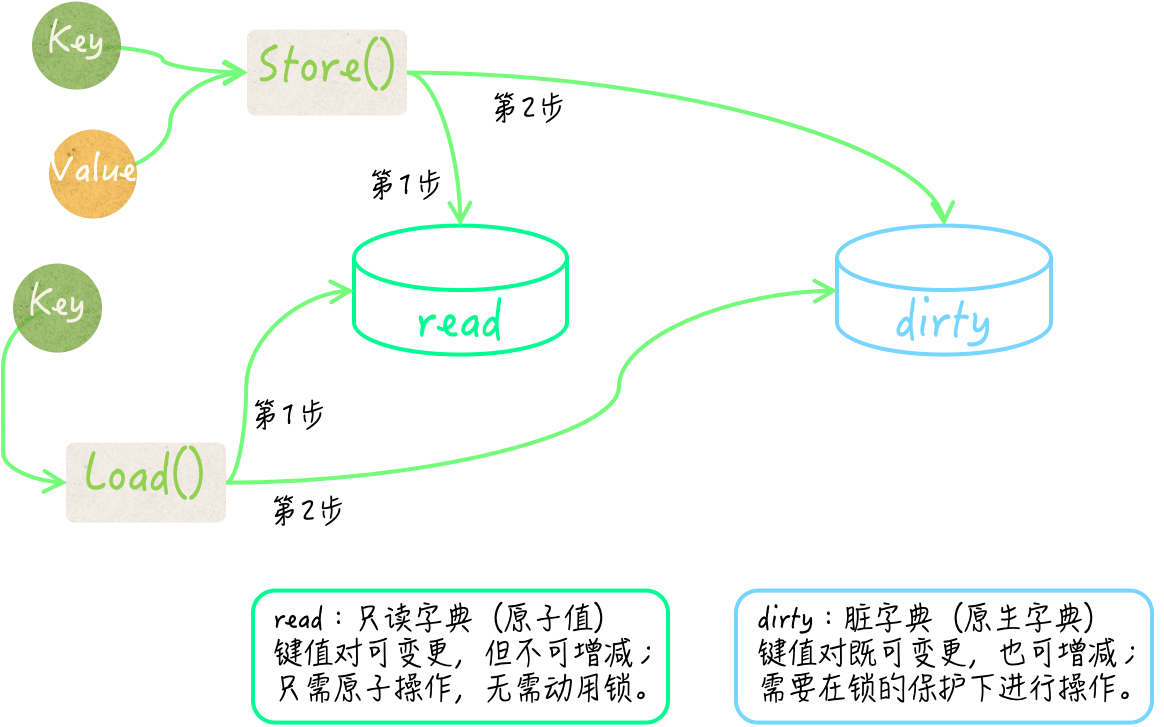

顺便说一句，只有当一个键值对应该被删除，但却仍然存在于只读字典中的时候，才会被用标记为“已删除”的方式进行逻辑删除，而不会直接被物理删除。

这种情况会在重建脏字典以后的一段时间内出现。不过，过不了多久，它们就会被真正删除掉。在查找和遍历键值对的时候，已被逻辑删除的键值对永远会被无视。

对于删除键值对，`sync.Map`会先去检查只读字典中是否有对应的键。如果没有，脏字典中可能有，那么它就会在锁的保护下，试图从脏字典中删掉该键值对。

最后，`sync.Map`会把该键值对中指向值的那个指针置为`nil`，这是另一种逻辑删除的方式。

除此之外，还有一个细节需要注意，只读字典和脏字典之间是会互相转换的。在脏字典中查找键值对次数足够多的时候，`sync.Map`会把脏字典直接作为只读字典，保存在它的`read`字段中，然后把代表脏字典的`dirty`字段的值置为`nil`。

在这之后，一旦再有新的键值对存入，它就会依据只读字典去重建脏字典。这个时候，它会把只读字典中已被逻辑删除的键值对过滤掉。理所当然，这些转换操作肯定都需要在锁的保护下进行。

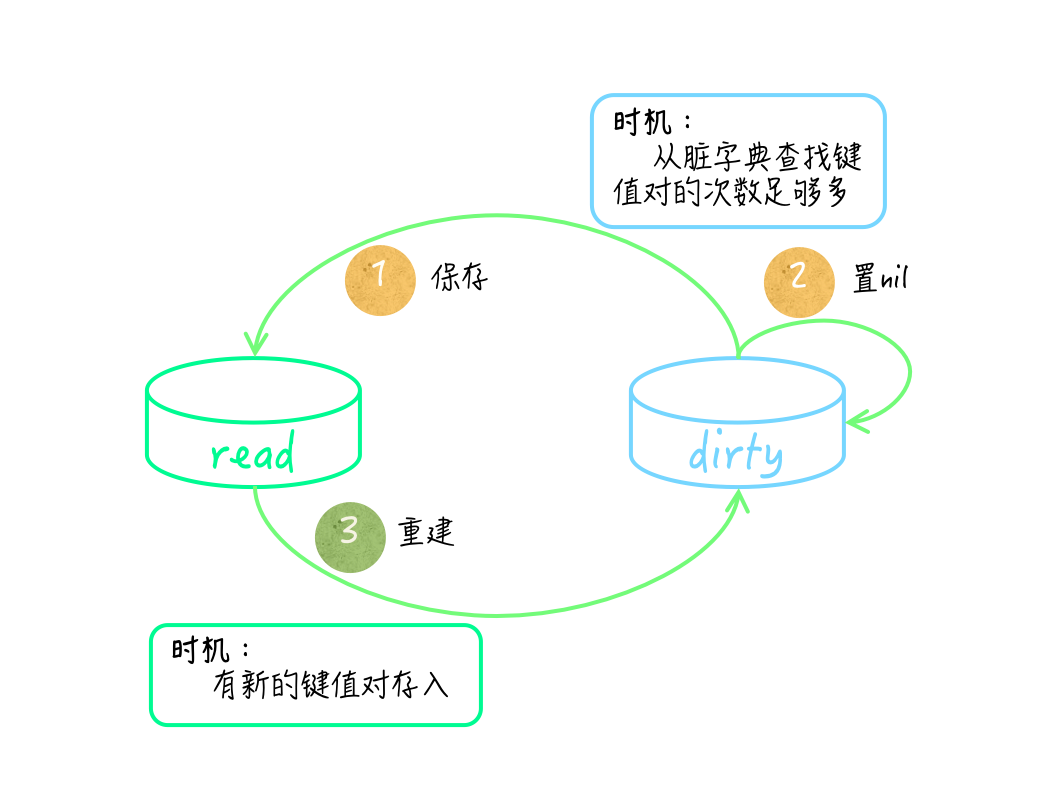

综上所述，`sync.Map`的只读字典和脏字典中的键值对集合，并不是实时同步的，它们在某些时间段内可能会有不同。

由于只读字典中键的集合不能被改变，所以其中的键值对有时候可能是不全的。相反，脏字典中的键值对集合总是完全的，并且其中不会包含已被逻辑删除的键值对。

因此，可以看出，在读操作有很多但写操作却很少的情况下，并发安全字典的性能往往会更好。在几个写操作当中，新增键值对的操作对并发安全字典的性能影响是最大的，其次是删除操作，最后才是修改操作。

如果被操作的键值对已经存在于`sync.Map`的只读字典中，并且没有被逻辑删除，那么修改它并不会使用到锁，对其性能的影响就会很小。

## 总结

这两篇文章中，我们讨论了`sync.Map`类型，并谈到了怎样保证并发安全字典中的键和值的类型正确性。

为了进一步明确并发安全字典中键值的实际类型，这里大致有两种方案可选。

1. 其中一种方案是，在编码时就完全确定键和值的类型，然后利用Go语言的编译器帮我们做检查。

2. 另一种方案是，接受动态的类型设置，并在程序运行的时候通过反射操作进行检查。

这两种方案各有利弊，前一种方案在扩展性方面有所欠缺，而后一种方案通常会影响到程序的性能。在实际使用的时候，我们一般都需要通过客观的测试来帮助决策。

另外，在有些时候，与单纯使用原生字典和互斥锁的方案相比，使用sync.Map可以显著地减少锁的争用。sync.Map本身确实也用到了锁，但是，它会尽可能地避免使用锁。

这就要说到`sync.Map`对其持有两个原生字典的巧妙使用了。这两个原生字典一个被称为只读字典，另一个被称为脏字典。通过对它们的分析，我们知道了并发安全字典的适用场景，以及每种操作对其性能的影响程度。

## 思考题：
今天的思考题是：关于保证并发安全字典中的键和值的类型正确性，你还能想到其他的方案吗？
使用泛型加RWMUTEX互斥锁自己写一个。